In [ ]:
#@title Initial Setup

import os, sys
from IPython.utils import io

with io.capture_output() as cap:
  !apt install tree
  !pip install ann_visualizer
  !pip install geopandas
  # https://github.com/tkrajina/srtm.py
  # pip install git+https://github.com/tkrajina/srtm.py

%cd /content/drive/My Drive/Posgrado/Geophysics/Colab/ML/test
# https://ai.googleblog.com/2019/08/turbo-improved-rainbow-colormap-for.html
# https://gist.github.com/FedeMiorelli/640bbc66b2038a14802729e609abfe89
!wget -q -nc https://gist.githubusercontent.com/FedeMiorelli/640bbc66b2038a14802729e609abfe89/raw/1aa7f0d0fdc1d3d4cc21b2e70991edd55e6f8485/turbo_colormap_mpl.py
with open('installs_IA.txt', 'w') as f:
    f.write(cap.stdout)
!tree -altrh ./

import time
from IPython.display import set_matplotlib_formats
from IPython.display import display, display_svg
from IPython.display import Markdown, Math, Latex
from IPython.display import Javascript, IFrame, HTML

from io import StringIO
import requests

import pandas as pd
import numpy as np

import fiona
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon
from shapely.geometry.polygon import Polygon

import matplotlib.pyplot as plt
set_matplotlib_formats('pdf', 'svg')
from matplotlib import style
#style.use('classic')
import turbo_colormap_mpl
import seaborn as sns
import graphviz 
from graphviz import Source

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn import tree

from keras import Input
from keras.layers import Dense
from keras.backend import clear_session
from keras.models import Sequential, load_model
from keras.utils.vis_utils import plot_model
from ann_visualizer.visualize import ann_viz
from keras.callbacks import Callback
from tqdm.keras import TqdmCallback

# Avoids scroll-in-the-scroll in the entire Notebook
# https://stackoverflow.com/a/66891328
def resize_colab_cell():
  display(Javascript(
      'google.colab.output.setIframeHeight(0, true, {maxHeight: 6000})'
      ))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

def dLatex(self):
  return display(Latex(self))

def dMarkdown(self):
  return display(Markdown(self))

# https://stackoverflow.com/a/52200840
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start=time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time()-self.epoch_time_start)



/content/drive/My Drive/Posgrado/Geophysics/Colab/ML/test
./
├── [233K]  installs_IA.txt
├── [163K]  NeuralNetwork_pairplot.pdf
├── [152K]  SVR-linear_pairplot.pdf
├── [165K]  SVR-poly_pairplot.pdf
├── [161K]  SVR-rbf_pairplot.pdf
├── [136K]  LinearReg_pairplot.pdf
├── [ 14K]  SVR-linear_heatmap.pdf
├── [ 795]  SVR-linear_corr.csv
├── [ 14K]  NeuralNetwork_heatmap.pdf
├── [ 795]  NeuralNetwork_corr.csv
├── [ 15K]  SVR-rbf_heatmap.pdf
├── [ 795]  SVR-rbf_corr.csv
├── [ 15K]  SVR-poly_heatmap.pdf
├── [ 791]  SVR-poly_corr.csv
├── [ 14K]  LinearReg_heatmap.pdf
├── [ 793]  LinearReg_corr.csv
├── [586K]  area_predict_NeuralNetwork.csv
├── [784K]  area_predict_SVR-linear.csv
├── [786K]  area_predict_SVR-poly.csv
├── [790K]  area_predict_SVR-rbf.csv
├── [784K]  area_predict_LinearReg.csv
├── [363K]  NeuralNetwork_diff_train.csv
├── [ 16K]  NeuralNetwork_diff_test_hist.pdf
├── [182K]  NeuralNetwork_diff_test.csv
├── [ 16K]  NeuralNetwork_diff_train_hist.pdf
├── [ 57K]  my_model.h5
├── [464K]  

In [ ]:
#@title Train and Test Sorted
colomb97 = pd.read_csv(
    'colomb97.csv',
    index_col=0    
    )
colomb97_train = pd.read_csv(
    'colomb97_train.csv',
    index_col=0    
    )
colomb97_test = pd.read_csv(
    'colomb97_test.csv',
    index_col=0    
    )

dMarkdown('**Train Sorted:**')
display(colomb97_train.sort_index())

dMarkdown('**Test Sorted:**')
display(colomb97_test.sort_index())

<IPython.core.display.Javascript object>

**Train Sorted:**

,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
station_id,,,,,,
2,7.56000,-73.16500,975.00,4.46,-104.60,-93.72
6,7.69000,-73.09670,1290.00,38.49,-105.90,-93.75
8,7.74500,-73.05500,2050.00,136.63,-92.76,-75.37
9,7.69500,-73.28330,512.00,-17.91,-75.21,-70.53
11,7.79667,-73.34830,204.00,-65.13,-87.96,-82.56
...,...,...,...,...,...,...
9046,3.88333,-76.99333,60.58,-55.96,-62.74,-62.07
9047,3.88833,-77.01667,51.83,-58.04,-63.84,-63.33
9048,3.88333,-77.01500,39.15,-59.40,-63.78,-63.23


**Test Sorted:**

,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
station_id,,,,,,
1,7.57167,-73.19830,750.00,-17.42,-101.30,-92.48
3,7.65000,-73.22000,550.00,-31.69,-93.24,-86.08
4,7.65500,-73.17830,730.00,-16.26,-97.95,-88.07
5,7.66000,-73.12670,1000.00,-1.60,-113.50,-99.03
7,7.72833,-73.07670,1650.00,80.20,-104.40,-88.80
...,...,...,...,...,...,...
9028,3.84667,-76.81833,163.17,-5.39,-23.65,-22.27
9034,3.86500,-76.87500,181.85,-8.47,-28.82,-27.33
9036,3.86833,-76.89500,204.99,-11.82,-34.76,-33.35


In [ ]:
#@title X and Y Columns
X_columns = colomb97.columns[0:3]
Y_columns = colomb97.columns[-3:]

dMarkdown('**X_columns:**')
print(X_columns)
dMarkdown('**Y_columns:**')
print(Y_columns)

X_train = colomb97_train[X_columns]
Y_train = colomb97_train[Y_columns]
X_test  = colomb97_test[X_columns]
Y_test  = colomb97_test[Y_columns]

print('\n')
dMarkdown('**Train:**')
display(pd.concat([X_train,Y_train], axis=1).sample(5))
print('\n')
dMarkdown('**Test:**')
display(pd.concat([X_test,Y_test], axis=1).sample(5))

<IPython.core.display.Javascript object>

**X_columns:**

Index(['latitude', 'longitude', 'sea_level_elev_m'], dtype='object')


**Y_columns:**

Index(['Free_air_anom', 'Bouguer_anom_simp', 'Bouguer_anom_267'], dtype='object')




**Train:**

,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
station_id,,,,,,
2444,5.03333,-73.98000,2584.95,110.09,-179.20,-156.20
2002,4.56000,-74.58000,478.86,-109.00,-162.60,-158.00
6408,6.18667,-67.50167,199.90,30.58,8.21,9.46
749,9.45833,-75.45000,40.61,0.97,-3.58,-2.79
3752,10.02833,-75.08333,121.10,4.92,-8.63,-7.54


**Test:**

,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
station_id,,,,,,
2044,4.89567,-74.60433,1481.87,17.60,-148.20,-136.10
174,6.31333,-75.26000,1958.00,134.72,-84.38,-66.78
1506,5.51583,-73.94750,2074.76,94.97,-137.20,-118.10
8189,10.66000,-75.04667,23.30,-7.64,-10.25,-9.46
3272,6.16333,-75.64000,1694.80,124.47,-65.18,-50.72


In [ ]:
#@title Regressors
#@markdown This might take several minutes.

# https://scikit-learn.org/stable/modules/tree.html
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html

my_depth = 20
rng = np.random.RandomState(137)
regr_dict={
    'LinearReg': LinearRegression(),
    'SVR-rbf': MultiOutputRegressor(
        SVR(
            kernel='rbf', # 'linear', 'poly', 'rbf'
            )
        ),
    'SVR-poly': MultiOutputRegressor(
        SVR(
            kernel='poly', # 'linear', 'poly', 'rbf'
            )
        ),
    'SVR-linear': MultiOutputRegressor(
        SVR(
            kernel='linear', # 'linear', 'poly', 'rbf'
            )
        ),
    # 'DecisionTree': DecisionTreeRegressor(max_depth=my_depth),
    # 'AdaBoostTree': MultiOutputRegressor(
    #     AdaBoostRegressor(
    #         DecisionTreeRegressor(max_depth=my_depth),
    #         n_estimators=300,
    #         random_state=rng
    #         )
    #     ),
    # 'RandomForest': MultiOutputRegressor(
    #     RandomForestRegressor(
    #         max_depth=my_depth,
    #         n_estimators=300,
    #         random_state=rng
    #         )
    #     ),
    }

for name, regr in regr_dict.items():
  dMarkdown(f'**{name}**')
  %time display(regr.fit(X_train, Y_train))

<IPython.core.display.Javascript object>

**LinearReg**

LinearRegression()

CPU times: user 13.1 ms, sys: 1.67 ms, total: 14.8 ms
Wall time: 44.3 ms


**SVR-rbf**

MultiOutputRegressor(estimator=SVR())

CPU times: user 6.55 s, sys: 197 ms, total: 6.75 s
Wall time: 6.75 s


**SVR-poly**

MultiOutputRegressor(estimator=SVR(kernel='poly'))

CPU times: user 5.04 s, sys: 59.2 ms, total: 5.1 s
Wall time: 5.1 s


**SVR-linear**

MultiOutputRegressor(estimator=SVR(kernel='linear'))

CPU times: user 17min 33s, sys: 936 ms, total: 17min 34s
Wall time: 17min 29s


In [ ]:
#@title Linear Regression
print(
    'slope:',
    regr_dict['LinearReg'].coef_
    )
print(
    'y_intercept:',
    regr_dict['LinearReg'].intercept_
    )

<IPython.core.display.Javascript object>

slope: [[10.21643612 -5.19284412  0.08553017]
 [10.21641415 -5.19265953 -0.02637017]
 [10.39337048 -5.21732408 -0.01641221]]
y_intercept: [-501.89809316 -501.88387305 -505.24036087]


<IPython.core.display.Javascript object>

**LinearReg:**

r2_train:   0.4945062068677633
mse_train: 2242.907266045396
-------------------------------


**Corr by Columns:**

Free_air_anom        0.852066
Bouguer_anom_simp    0.650975
Bouguer_anom_267     0.577697
dtype: float64

-------------------------------


**max diff:**

Free_air_anom        190.020280
Bouguer_anom_simp    190.015140
Bouguer_anom_267     191.572645
dtype: float64


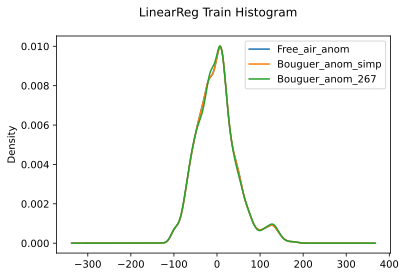

**SVR-rbf:**

r2_train:   0.4311887012278514
mse_train: 2530.497452783927
-------------------------------


**Corr by Columns:**

Free_air_anom        0.832387
Bouguer_anom_simp    0.595817
Bouguer_anom_267     0.503224
dtype: float64

-------------------------------


**max diff:**

Free_air_anom        198.328720
Bouguer_anom_simp    192.690816
Bouguer_anom_267     192.505854
dtype: float64


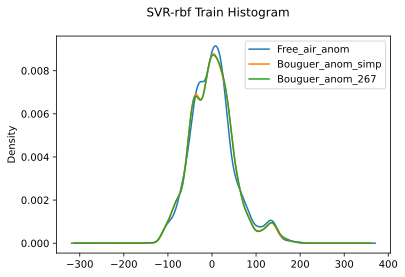

**SVR-poly:**

r2_train:   0.2941619751099582
mse_train: 3187.789398700184
-------------------------------


**Corr by Columns:**

Free_air_anom        0.763691
Bouguer_anom_simp    0.443410
Bouguer_anom_267     0.326660
dtype: float64

-------------------------------


**max diff:**

Free_air_anom        193.464875
Bouguer_anom_simp    197.913924
Bouguer_anom_267     193.301421
dtype: float64


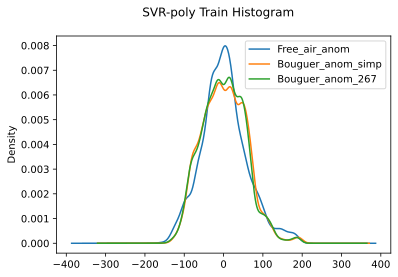

**SVR-linear:**

r2_train:   0.48745449631804344
mse_train: 2273.543400609653
-------------------------------


**Corr by Columns:**

Free_air_anom        0.850897
Bouguer_anom_simp    0.648431
Bouguer_anom_267     0.574403
dtype: float64

-------------------------------


**max diff:**

Free_air_anom        211.574841
Bouguer_anom_simp    211.637889
Bouguer_anom_267     215.023682
dtype: float64


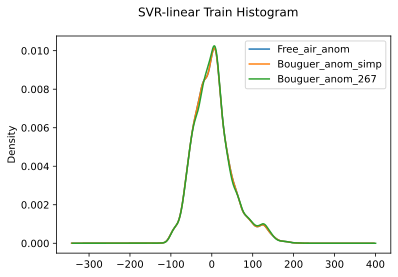

CPU times: user 15 s, sys: 118 ms, total: 15.1 s
Wall time: 15.3 s


In [ ]:
#@title Predict Train Stats
%%time

for name, regr in regr_dict.items():
  dMarkdown(f'**{name}:**')
  Y_pred_train = pd.DataFrame(
      regr.predict(X_train),
      columns=Y_train.columns,
      index=Y_train.index
      )
  r2_train = r2_score(Y_train, Y_pred_train)
  mse_train = mean_squared_error(Y_train, Y_pred_train)
  print('r2_train:  ', r2_train)
  print('mse_train:', mse_train)
  print('-------------------------------')
  dMarkdown('**Corr by Columns:**')
  display(Y_train.corrwith(Y_pred_train))
  print('-------------------------------')
  diff=Y_train-Y_pred_train
  dMarkdown('**max diff:**')
  print(abs(diff).max())
  diff.plot.kde()
  plt.yscale('linear')#'linear', 'log'
  plt.suptitle(name+' Train Histogram')
  diff.to_csv(name+'_diff_train.csv')
  plt.savefig(
      name+'_diff_train_hist.pdf',
      bbox_inches='tight'
      )
  plt.show()

<IPython.core.display.Javascript object>

**LinearReg:**

r2_test:   0.4857450854806273
mse_test: 2254.8999170533853
-------------------------------


**Corr by Columns:**

Free_air_anom        0.853380
Bouguer_anom_simp    0.639993
Bouguer_anom_267     0.565919
dtype: float64

-------------------------------


**max diff:**

Free_air_anom        178.854030
Bouguer_anom_simp    178.859338
Bouguer_anom_267     176.153179
dtype: float64


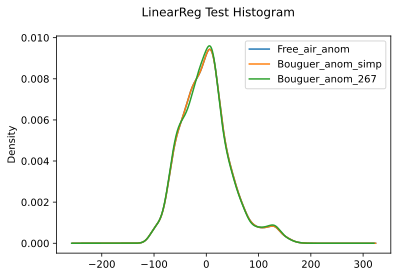

**SVR-rbf:**

r2_test:   0.41675117946238016
mse_test: 2564.041131167423
-------------------------------


**Corr by Columns:**

Free_air_anom        0.832557
Bouguer_anom_simp    0.576831
Bouguer_anom_267     0.480550
dtype: float64

-------------------------------


**max diff:**

Free_air_anom        196.602317
Bouguer_anom_simp    192.030608
Bouguer_anom_267     191.822027
dtype: float64


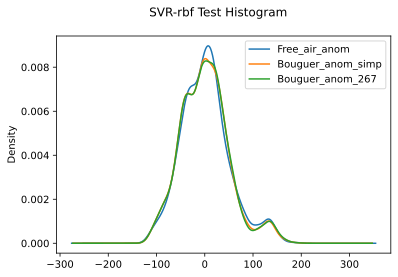

**SVR-poly:**

r2_test:   0.2854114648792652
mse_test: 3208.0905160062866
-------------------------------


**Corr by Columns:**

Free_air_anom        0.759255
Bouguer_anom_simp    0.433607
Bouguer_anom_267     0.313352
dtype: float64

-------------------------------


**max diff:**

Free_air_anom        218.638043
Bouguer_anom_simp    194.187216
Bouguer_anom_267     189.692728
dtype: float64


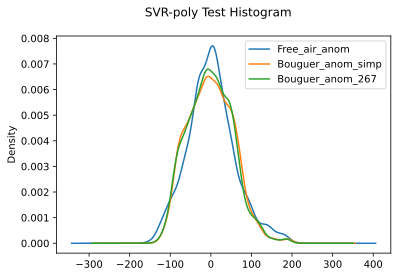

**SVR-linear:**

r2_test:   0.4829742450974739
mse_test: 2266.738024788969
-------------------------------


**Corr by Columns:**

Free_air_anom        0.852831
Bouguer_anom_simp    0.639715
Bouguer_anom_267     0.565916
dtype: float64

-------------------------------


**max diff:**

Free_air_anom        183.424901
Bouguer_anom_simp    183.475948
Bouguer_anom_267     182.513493
dtype: float64


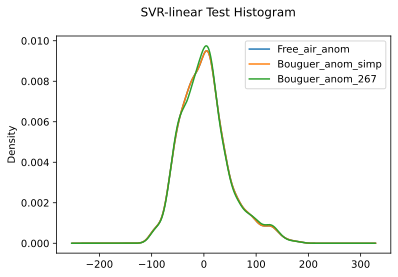

CPU times: user 8.56 s, sys: 109 ms, total: 8.66 s
Wall time: 8.79 s


In [ ]:
#@title Predict Test Stats
%%time

for name, regr in regr_dict.items():
  dMarkdown(f'**{name}:**')
  Y_pred_test = pd.DataFrame(
      regr.predict(X_test),
      columns=Y_test.columns,
      index=Y_test.index
      )
  r2_test = r2_score(Y_test, Y_pred_test)
  mse_test = mean_squared_error(Y_test, Y_pred_test)
  print('r2_test:  ', r2_test)
  print('mse_test:', mse_test)
  print('-------------------------------')
  dMarkdown('**Corr by Columns:**')
  display(Y_test.corrwith(Y_pred_test))
  print('-------------------------------')
  diff=Y_test-Y_pred_test
  dMarkdown('**max diff:**')
  print(abs(diff).max())
  diff.plot.kde()
  plt.yscale('linear')#'linear', 'log'
  plt.suptitle(name+' Test Histogram')
  diff.to_csv(name+'_diff_test.csv')
  plt.savefig(
      name+'_diff_test_hist.pdf',
      bbox_inches='tight'
      )
  plt.show()

In [ ]:
#@title Neural Network
#@markdown This might take several minutes.
%%time

clear_session()
try:
  del nfit
  del nnet
except:
  pass

nnet = Sequential(name='Sequential')
nnet.add(Dense(5, name='hiden0',
               input_dim=3,
               kernel_initializer='random_normal',
               bias_initializer='zeros',
               activation='softplus')
)
nnet.add(Dense(3, name='hiden1', activation='softplus'))
nnet.add(Dense(5, name='hiden2', activation='softplus'))
nnet.add(Dense(3, name='hiden3', activation='softplus'))
nnet.add(Dense(5, name='hiden4', activation='softplus'))
nnet.add(Dense(3, name='Output'))

display(nnet.summary())
tqdm_callback = TqdmCallback(verbose=0)
time_callback = TimeHistory()
nnet.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
    )
netfit = nnet.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=10_000,
    verbose=0,
    callbacks=[
      tqdm_callback,
      time_callback
      ]
    )

<IPython.core.display.Javascript object>

Model: "Sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hiden0 (Dense)              (None, 5)                 20        
                                                                 
 hiden1 (Dense)              (None, 3)                 18        
                                                                 
 hiden2 (Dense)              (None, 5)                 20        
                                                                 
 hiden3 (Dense)              (None, 3)                 18        
                                                                 
 hiden4 (Dense)              (None, 5)                 20        
                                                                 
 Output (Dense)              (None, 3)                 18        
                                                                 
Total params: 114
Trainable params: 114
Non-trainable pa

None

0epoch [00:00, ?epoch/s]

CPU times: user 1h 20min, sys: 4min 55s, total: 1h 24min 55s
Wall time: 1h 8min 38s


<IPython.core.display.Javascript object>

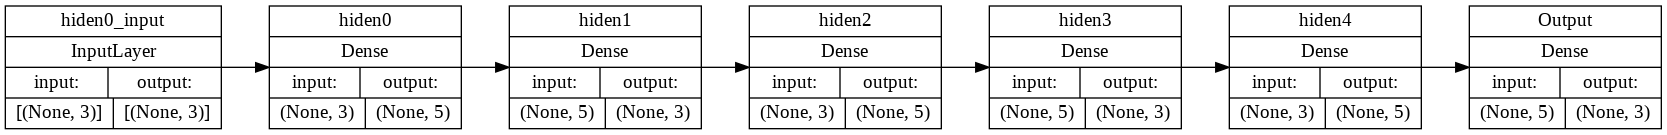

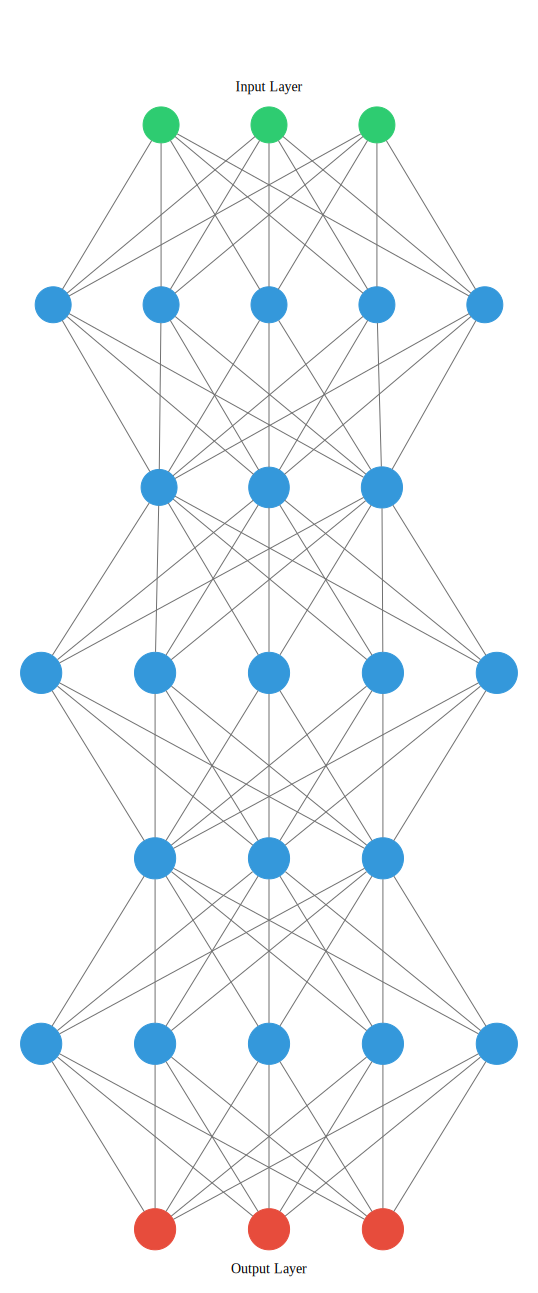

In [ ]:
#@title Neural Network Diagrams
nnet_filename='neural_network'
display(plot_model(
    nnet,
    to_file=nnet_filename+'_diagram.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='LR'# LR, TB
    )
)
ann_viz(
    nnet,
    view=True,
    filename=nnet_filename,
    title=''
    )
display(Source.from_file(nnet_filename))

<IPython.core.display.Javascript object>

,loss,mse,val_loss,val_mse,times
0,9388.486328,9388.486328,9462.631836,9462.631836,NaN
1,8136.157715,8136.157715,5348.498047,5348.498047,NaN
2,3936.680664,3936.680664,3571.339844,3571.339844,NaN
3,3428.493652,3428.493652,3391.649414,3391.649414,NaN
4,3175.388916,3175.388916,2965.836670,2965.836670,NaN
...,...,...,...,...,...
9995,1339.674316,1339.674316,1461.020874,1461.020874,403.663826
9996,1326.092529,1326.092529,1399.867065,1399.867065,398.796511
9997,1351.197388,1351.197388,1482.332153,1482.332153,394.165874
9998,1321.434204,1321.434204,1388.216919,1388.216919,394.100404


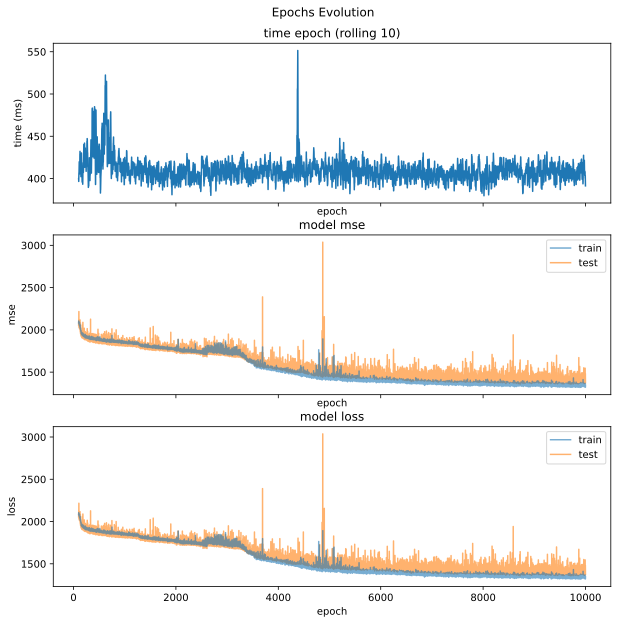

CPU times: user 2.21 s, sys: 80.9 ms, total: 2.29 s
Wall time: 2.49 s


In [ ]:
#@title Epochs Evolution
%%time

!rm -f my_model.h5
model_filename = 'my_model.h5'
name='NeuralNetwork'
netfit.model.save(model_filename)
regr_dict[name] = load_model(model_filename)
regr = regr_dict[name]

dfhist = pd.DataFrame.from_dict(netfit.history)
nnet_times = 1000*pd.Series(time_callback.times)
dfhist = dfhist.assign(
    times=pd.Series(nnet_times).rolling(10).mean()
    )

dfhist.to_csv('dfhist.csv')
display(dfhist)

dfhist_new = dfhist[100:]
my_alpha = .6
fig, (ax0,ax1,ax2) = plt.subplots(3,1,
                              figsize=(10,10),
                              sharey=False, sharex=True,
                              gridspec_kw={'hspace': 2/10}
                              )
ax0.plot(dfhist_new['times'])
ax0.set_title('time epoch (rolling 10)')
ax0.set_ylabel('time (ms)')
ax0.set_xlabel('epoch')
ax1.plot(dfhist_new['mse'],
         alpha=my_alpha,
         zorder=2
         )
ax1.plot(dfhist_new['val_mse'],
         alpha=my_alpha,
         zorder=1
         )
ax1.set_title('model mse')
ax1.set_ylabel('mse')
ax1.set_xlabel('epoch')
ax1.legend(
    ['train', 'test'],
    loc='upper right'
    )
ax2.plot(dfhist_new['loss'],
         alpha=my_alpha,
         zorder=2
         )
ax2.plot(dfhist_new['val_loss'],
         alpha=my_alpha,
         zorder=1
         )
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(
    ['train', 'test'],
    loc='upper right'
    )
plt.suptitle('Epochs Evolution',y=.93)
plt.savefig(
    'epochs_evolution.pdf',
    bbox_inches='tight'
    )
plt.show()

<IPython.core.display.Javascript object>

r2_train:   0.7089848796368271
mse_train: 1294.8659071210363
-------------------------------


**Corr by Columns:**

Free_air_anom        0.916777
Bouguer_anom_simp    0.818432
Bouguer_anom_267     0.786174
dtype: float64

-------------------------------


**max diff:**

Free_air_anom        161.282754
Bouguer_anom_simp    182.289575
Bouguer_anom_267     180.471761
dtype: float64


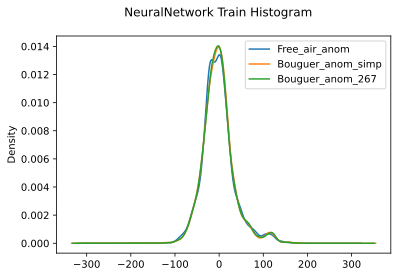

CPU times: user 1.6 s, sys: 61.4 ms, total: 1.66 s
Wall time: 1.73 s


In [ ]:
#@title Predict Neural Network Train Stats
%%time

Y_pred_train = pd.DataFrame(
    regr.predict(X_train),
    columns=Y_train.columns,
    index=Y_train.index
    )
r2_train = r2_score(Y_train, Y_pred_train)
mse_train = mean_squared_error(Y_train, Y_pred_train)
print('r2_train:  ', r2_train)
print('mse_train:', mse_train)
print('-------------------------------')
dMarkdown('**Corr by Columns:**')
display(Y_train.corrwith(Y_pred_train))
print('-------------------------------')
diff=Y_train-Y_pred_train
dMarkdown('**max diff:**')
print(abs(diff).max())
diff.plot.kde()
plt.yscale('linear')#'linear', 'log'
plt.suptitle(name+' Train Histogram')
diff.to_csv(name+'_diff_train.csv')
plt.savefig(
    name+'_diff_train_hist.pdf',
    bbox_inches='tight'
    )
plt.show()

<IPython.core.display.Javascript object>

r2_test:   0.6878657216525129
mse_test: 1374.0857233046038
-------------------------------


**Corr by Columns:**

Free_air_anom        0.912043
Bouguer_anom_simp    0.802841
Bouguer_anom_267     0.767416
dtype: float64

-------------------------------


**max diff:**

Free_air_anom        158.818794
Bouguer_anom_simp    176.739221
Bouguer_anom_267     172.476666
dtype: float64


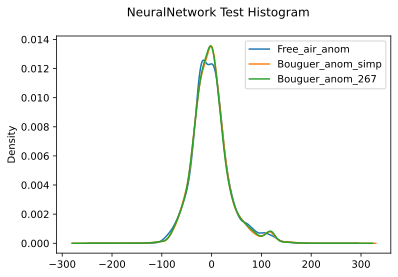

CPU times: user 1.01 s, sys: 31 ms, total: 1.04 s
Wall time: 1.07 s


In [ ]:
#@title Predict Neural Network Test Stats
%%time

Y_pred_test = pd.DataFrame(
    regr.predict(X_test),
    columns=Y_test.columns,
    index=Y_test.index
    )
r2_test = r2_score(Y_test, Y_pred_test)
mse_test = mean_squared_error(Y_test, Y_pred_test)
print('r2_test:  ', r2_test)
print('mse_test:', mse_test)
print('-------------------------------')
dMarkdown('**Corr by Columns:**')
display(Y_test.corrwith(Y_pred_test))
print('-------------------------------')
diff=Y_test-Y_pred_test
dMarkdown('**max diff:**')
print(abs(diff).max())
diff.plot.kde()
plt.yscale('linear')#'linear', 'log'
plt.suptitle(name+' Test Histogram')
diff.to_csv(name+'_diff_test.csv')
plt.savefig(
    name+'_diff_test_hist.pdf',
    bbox_inches='tight'
    )
plt.show()

<IPython.core.display.Javascript object>

,Name,geometry
0,my_rectangle,"POLYGON ((-75.25000 6.85000, -75.25000 5.75000..."


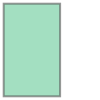

,latitude,longitude,sea_level_elev_m
0,5.75,-75.92,1088.0
1,5.75,-75.91,1152.0
2,5.75,-75.90,1158.0
3,5.75,-75.89,1092.0
4,5.75,-75.88,1479.0
...,...,...,...
7654,6.85,-75.28,1680.0
7655,6.85,-75.27,1887.0
7656,6.85,-75.26,2006.0
7657,6.85,-75.25,2039.0


CPU times: user 59.3 ms, sys: 22.2 ms, total: 81.5 ms
Wall time: 916 ms


In [ ]:
#@title Load `my_rectangle.shp`
%%time
my_rectangle_gpd = gpd.read_file('MGN2020/my_rectangle.shp')
display(my_rectangle_gpd)
my_rectangle = my_rectangle_gpd['geometry'].values[0]
display(my_rectangle)


bounds=np.reshape(my_rectangle.bounds,(2,2))
lon_min=bounds[0,0]
lat_min=bounds[0,1]
lon_max=bounds[1,0]
lat_max=bounds[1,1]

lons, lats, elevs = np.load(
    'elevs_data.npy',
    allow_pickle=True
    )
my_shape = np.shape(elevs)

srtmdf = pd.read_csv(
    'my_rectangle_srtm.csv',
    index_col=[0]
    ).rename(columns={
        'SRTM': 'sea_level_elev_m'
        })
display(srtmdf)

In [ ]:
%%time
#@title Area Predict

for name, regr in regr_dict.items():
  area_predict = pd.concat([
             srtmdf,
             pd.DataFrame(
                 regr_dict[name].predict(srtmdf),
                 columns=Y_columns
                 )], axis=1
            )
  area_predict.to_csv('area_predict_'+name+'.csv')
  print('Saved', 'area_predict_'+name+'.csv')

names=regr_dict.keys()
print(names)
area_predict_dict = {
    name: pd.read_csv(
        'area_predict_'+name+'.csv',
        index_col=[0])
        for name in names
        }

for name in names:
  dMarkdown(f'**{name}:**')
  display(area_predict_dict[name])

<IPython.core.display.Javascript object>

Saved area_predict_LinearReg.csv
Saved area_predict_SVR-rbf.csv
Saved area_predict_SVR-poly.csv
Saved area_predict_SVR-linear.csv
Saved area_predict_NeuralNetwork.csv
dict_keys(['LinearReg', 'SVR-rbf', 'SVR-poly', 'SVR-linear', 'NeuralNetwork'])


**LinearReg:**

,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
0,5.75,-75.92,1088.0,44.143960,-77.603521,-67.235717
1,5.75,-75.91,1152.0,49.565962,-79.343139,-68.338271
2,5.75,-75.90,1158.0,50.027215,-79.553286,-68.488918
3,5.75,-75.89,1092.0,44.330295,-77.864782,-67.457886
4,5.75,-75.88,1479.0,77.378541,-88.121963,-73.861583
...,...,...,...,...,...,...
7654,6.85,-75.28,1680.0,102.692477,-85.299907,-68.858123
7655,6.85,-75.27,1887.0,120.345293,-90.810458,-72.307623
7656,6.85,-75.26,2006.0,130.471454,-94.000434,-74.312849
7657,6.85,-75.25,2039.0,133.242021,-94.922576,-74.906625


**SVR-rbf:**

,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
0,5.75,-75.92,1088.0,13.813908,-107.793707,-98.497042
1,5.75,-75.91,1152.0,21.670488,-107.577994,-97.691670
2,5.75,-75.90,1158.0,22.417261,-107.541427,-97.600141
3,5.75,-75.89,1092.0,14.298044,-107.790577,-98.456867
4,5.75,-75.88,1479.0,62.492732,-104.124914,-91.267670
...,...,...,...,...,...,...
7654,6.85,-75.28,1680.0,85.163606,-103.684911,-88.917965
7655,6.85,-75.27,1887.0,104.995116,-106.843851,-89.927500
7656,6.85,-75.26,2006.0,114.730563,-110.413223,-92.159942
7657,6.85,-75.25,2039.0,117.230734,-111.599886,-92.963272


**SVR-poly:**

,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
0,5.75,-75.92,1088.0,2.353159,-73.101806,-65.552863
1,5.75,-75.91,1152.0,4.783889,-74.252356,-66.408866
2,5.75,-75.90,1158.0,5.023181,-74.364830,-66.492292
3,5.75,-75.89,1092.0,2.495885,-73.169039,-65.602783
4,5.75,-75.88,1479.0,21.216022,-81.825025,-71.976931
...,...,...,...,...,...,...
7654,6.85,-75.28,1680.0,35.009674,-87.954021,-76.411553
7655,6.85,-75.27,1887.0,52.721590,-95.743545,-82.016792
7656,6.85,-75.26,2006.0,64.627864,-100.917707,-85.718535
7657,6.85,-75.25,2039.0,68.163378,-102.445774,-86.808822


**SVR-linear:**

,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
0,5.75,-75.92,1088.0,43.551721,-78.184553,-67.892753
1,5.75,-75.91,1152.0,49.051375,-79.843738,-68.901305
2,5.75,-75.90,1158.0,49.502919,-80.063290,-69.062712
3,5.75,-75.89,1092.0,43.687845,-78.495710,-68.172491
4,5.75,-75.88,1479.0,77.300245,-88.172165,-73.898766
...,...,...,...,...,...,...
7654,6.85,-75.28,1680.0,103.729082,-84.216677,-67.791286
7655,6.85,-75.27,1887.0,121.674935,-89.425304,-70.888490
7656,6.85,-75.26,2006.0,131.961589,-92.449659,-72.700369
7657,6.85,-75.25,2039.0,134.763115,-93.339385,-73.256137


**NeuralNetwork:**

,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
0,5.75,-75.92,1088.0,16.309444,-102.351074,-92.997680
1,5.75,-75.91,1152.0,23.322287,-98.968216,-89.252330
2,5.75,-75.90,1158.0,24.042622,-98.556145,-88.807940
3,5.75,-75.89,1092.0,16.722690,-102.175740,-92.799380
4,5.75,-75.88,1479.0,83.771545,-86.734950,-72.340690
...,...,...,...,...,...,...
7654,6.85,-75.28,1680.0,112.409805,-78.645210,-62.224674
7655,6.85,-75.27,1887.0,104.801704,-107.173780,-89.272120
7656,6.85,-75.26,2006.0,123.383040,-100.534180,-81.414320
7657,6.85,-75.25,2039.0,129.132870,-97.640500,-78.209970


CPU times: user 14.2 s, sys: 56.8 ms, total: 14.3 s
Wall time: 14.3 s


<IPython.core.display.Javascript object>

**LinearReg Heatmap_corr:**

Saved LinearReg_corr.csv


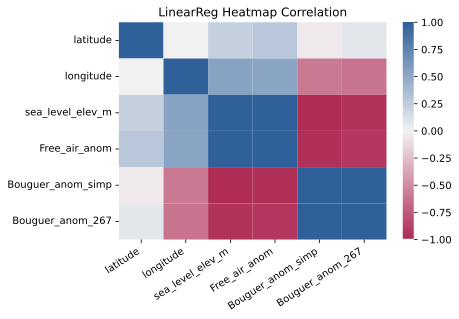

**SVR-rbf Heatmap_corr:**

Saved SVR-rbf_corr.csv


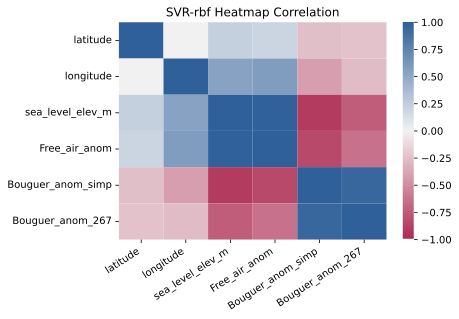

**SVR-poly Heatmap_corr:**

Saved SVR-poly_corr.csv


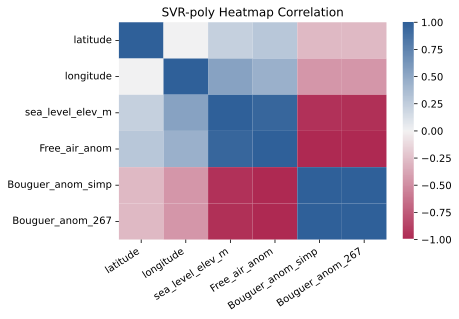

**SVR-linear Heatmap_corr:**

Saved SVR-linear_corr.csv


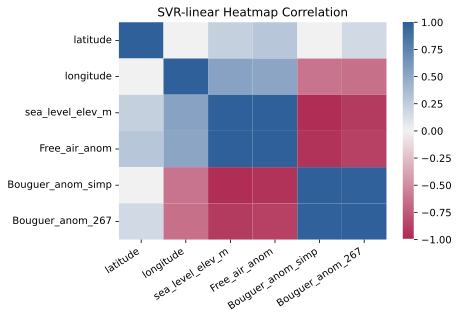

**NeuralNetwork Heatmap_corr:**

Saved NeuralNetwork_corr.csv


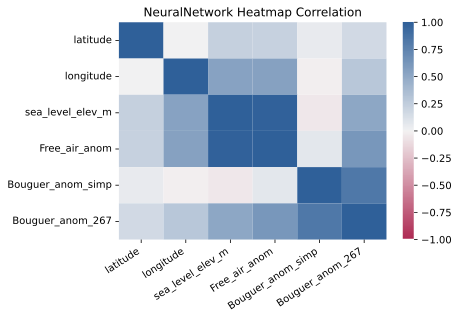

CPU times: user 3.1 s, sys: 646 ms, total: 3.75 s
Wall time: 3.26 s


In [ ]:
#@title Heatmap_corr
%%time

for name, area_predict in area_predict_dict.items():
  dMarkdown(f'**{name} Heatmap_corr:**')
  area_predict.corr().to_csv(name+'_corr.csv')
  print('Saved', name+'_corr.csv')
  heatmap=sns.heatmap(
      area_predict.corr(),
      vmin=-1,
      vmax=+1,
      cmap=sns.diverging_palette(
          0, 250,
          s=80, l=40,
          n=1000,
          as_cmap=True,
          center='light'
          )
      )
  heatmap.set_xticklabels(
      heatmap.get_xticklabels(),
      rotation=33,
      horizontalalignment='right'
      )
  plt.title(name+' Heatmap Correlation')
  plt.savefig(
      name+'_heatmap.pdf',
      bbox_inches='tight'
      )
  plt.show()

In [ ]:
#@title Pairplot
%%time

for name, area_predict in area_predict_dict.items():
  dMarkdown(f'**{name} Pairplot:**')
  sns.pairplot(
      area_predict.sample(1000),
      kind='kde',
      corner=True,
      height=2
      ).fig.suptitle(
          name+' Pairplot',
          y=1.02
          )
  plt.savefig(
      name+'_pairplot.pdf',
      bbox_inches='tight'
      )
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Predict mini-Maps
%%time

for name, area_predict in area_predict_dict.items():
  dMarkdown(f'**{name}:**')
  fig, axs = plt.subplots(1,3,
                          figsize=(10,10/3),
                          sharey=False,
                          gridspec_kw={'wspace': -1/3}
                          )
  for i, column  in enumerate(Y_columns):
    cf=axs[i].contourf(
        lons, lats,
        np.reshape(area_predict[column].to_numpy(),my_shape),
        levels=50,
        cmap='turbo'
        )
    # Rasterize the contour collections
    # https://stackoverflow.com/a/32911755
    for c in cf.collections:
      c.set_edgecolor('face')
    axs[i].set_aspect(1)
    axs[i].set_title(column)
  plt.suptitle(name+' Anomalies',y=1.01)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Predict Max-Min
for name in names:
  dMarkdown(f'**{name}:**')
  dMarkdown('**Max:**')
  display(area_predict_dict[name][Y_columns].max())
  dMarkdown('**Min:**')
  display(area_predict_dict[name][Y_columns].min())
  print('-------------------------------')

<IPython.core.display.Javascript object>

**LinearReg:**

**Max:**

Free_air_anom        239.691365
Bouguer_anom_simp    -48.385917
Bouguer_anom_267     -44.933814
dtype: float64

**Min:**

Free_air_anom         -6.423360
Bouguer_anom_simp   -129.120073
Bouguer_anom_267    -100.407178
dtype: float64

-------------------------------


**SVR-rbf:**

**Max:**

Free_air_anom        167.828765
Bouguer_anom_simp    -71.481041
Bouguer_anom_267     -68.655414
dtype: float64

**Min:**

Free_air_anom        -34.645852
Bouguer_anom_simp   -142.701982
Bouguer_anom_267    -113.935610
dtype: float64

-------------------------------


**SVR-poly:**

**Max:**

Free_air_anom        290.399212
Bouguer_anom_simp    -66.047704
Bouguer_anom_267     -60.172340
dtype: float64

**Min:**

Free_air_anom        -11.678228
Bouguer_anom_simp   -195.311697
Bouguer_anom_267    -151.943606
dtype: float64

-------------------------------


**SVR-linear:**

**Max:**

Free_air_anom        243.598813
Bouguer_anom_simp    -48.327908
Bouguer_anom_267     -45.064031
dtype: float64

**Min:**

Free_air_anom         -6.353158
Bouguer_anom_simp   -127.992158
Bouguer_anom_267     -99.068181
dtype: float64

-------------------------------


**NeuralNetwork:**

**Max:**

Free_air_anom        254.101400
Bouguer_anom_simp    -13.452331
Bouguer_anom_267      -6.973114
dtype: float64

**Min:**

Free_air_anom        -66.043180
Bouguer_anom_simp   -125.801285
Bouguer_anom_267    -102.036194
dtype: float64

-------------------------------


In [ ]:
#@title Max-Min Dictionaries
%%time

dMarkdown('**Max Dictionaries**')
vmaxdic = {column: max(
    [area_predict_dict[name][column].max() for name in names]
    ) for column in Y_columns}
print('vmaxdic:', vmaxdic)

dMarkdown('**Min Dictionaries**')
vmindic = {column: min(
    [area_predict_dict[name][column].min() for name in names]
    ) for column in Y_columns}
print('vmindic:', vmindic)

<IPython.core.display.Javascript object>

**Max Dictionaries**

vmaxdic: {'Free_air_anom': 290.3992123743621, 'Bouguer_anom_simp': -13.452331, 'Bouguer_anom_267': -6.973114}


**Min Dictionaries**

vmindic: {'Free_air_anom': -66.04318, 'Bouguer_anom_simp': -195.3116967974277, 'Bouguer_anom_267': -151.94360608370138}
CPU times: user 9.33 ms, sys: 1.04 ms, total: 10.4 ms
Wall time: 10.4 ms


In [ ]:
#@title Scale-Fix Predict mini-Maps
%%time

for name, area_predict in area_predict_dict.items():
  dMarkdown(f'**{name}:**')
  fig, axs = plt.subplots(2,2,
                          figsize=(10,10),
                          sharey=False, sharex=False,
                          gridspec_kw={'wspace': -2/5,
                                       'hspace': 2/10}
                          )
  cf=axs[0,0].contourf(
      lons, lats, elevs,
      levels=50,
      vmin=0,
      vmax=3500,
      cmap='gist_earth'
      )
  # Rasterize the contour collections
  # https://stackoverflow.com/a/32911755
  for c in cf.collections:
    c.set_edgecolor('face')
  axs[0,0].set_aspect(1)
  axs[0,0].set_title('Elevations')
  axdic = {Y_columns[0]: axs[0,1],
           Y_columns[1]: axs[1,0],
           Y_columns[2]: axs[1,1]
           }
  for column  in Y_columns:
    ax=axdic[column]
    cf=ax.contourf(
        lons, lats,
        np.reshape(area_predict[column].to_numpy(),my_shape),
        levels=50,
        vmin=vmindic[column],
        vmax=vmaxdic[column],
        cmap='turbo'
        )
    # Rasterize the contour collections
    # https://stackoverflow.com/a/32911755
    for c in cf.collections:
      c.set_edgecolor('face')
    ax.set_aspect(1)
    ax.set_title(column)
  plt.suptitle(name+' Anomalies',y=.93)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.